<h1><center> ANÁLISE DE DATASET FINANCEIRO OPERADORA DE CARTÃO DE CRÉDITO TAIWAN</center></h1>

<h3><center>Importando as bibliotecas e setando o pandas para não quebrar as colunas</center><h3>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

from sklearn.ensemble import ExtraTreesClassifier #testando com o modelo de extreme random forest
from sklearn.model_selection import train_test_split #para divisão do dataset entre treino e teste

import eli5
from eli5.sklearn import PermutationImportance #para verificação das features mais importantes


pd.set_option("expand_frame_repr", False)  # exibir toda as colunas lado a lado


<h3><center>Inicialização do Dataframe e Descrição dos Headers</h3></center>

In [2]:
df = pd.read_excel('default of credit card clients.xls',header=1)
descricoes= 'LIMITE SEXO EDUCACAO ESTADO_CIVIL IDADE'.split(' ')
hist_pagamento = 'STATUS_SET STATUS_AGO STATUS_JUL STATUS_JUN STATUS_MAI STATUS_ABR'.split(' ')
fatura = 'FAT_SET FAT_AGO FAT_JUL FAT_JUN FAT_MAI FAT_ABR'.split(' ')
pagamento_anterior = 'PAG_SET PAG_AGO PAG_JUL PAG_JUN PAG_MAI PAG_ABR'.split(' ')
falta_pagamento = ['PAGAMENTO']

<h3><center>Renomeação das Colunas para Nomes mais Descritivos</h3></center>

In [3]:
dicionario = {'LIMIT_BAL' : 'LIMITE', 'SEX' : 'SEXO', 'EDUCATION' : 'EDUCACAO', 'MARRIAGE' : 'ESTADO_CIVIL', 'AGE' : 'IDADE', \
              'PAY_0' : 'STATUS_SET','PAY_2' : 'STATUS_AGO', 'PAY_3' : 'STATUS_JUL', 'PAY_4' : 'STATUS_JUN', 'PAY_5' : 'STATUS_MAI', 'PAY_6' : 'STATUS_ABR', \
              'BILL_AMT1' : 'FAT_SET', 'BILL_AMT2' : 'FAT_AGO', 'BILL_AMT3' : 'FAT_JUL', 'BILL_AMT4' : 'FAT_JUN', 'BILL_AMT5' : 'FAT_MAI', 'BILL_AMT6' : 'FAT_ABR', \
              'PAY_AMT1' : 'PAG_SET', 'PAY_AMT2' : 'PAG_AGO', 'PAY_AMT3' : 'PAG_JUL', 'PAY_AMT4' : 'PAG_JUN', 'PAY_AMT5' : 'PAG_MAI', 'PAY_AMT6' : 'PAG_ABR', \
               'default payment next month' : 'PAGAMENTO'}

df.rename(columns=dicionario,inplace=True)

<h3><center>Declaração dos Valores Válidos para cada Coluna</h3></center>

In [4]:
val_gender = np.array([1,2])
val_educ = np.array([1,2,3,4])
val_est_civ = np.array([1,2,3])
val_hist = np.array([-1,*range(1,10)])

condicoes = {'SEXO' : val_gender,'EDUCACAO' : val_educ, 'ESTADO_CIVIL' : val_est_civ}

In [5]:
def confere_entradas():
    for coluna in df.columns:
        if coluna in condicoes:
            print('Valores fora do range na coluna {}: {}'.format(coluna,np.setdiff1d(df[coluna].unique(),condicoes[coluna])))
            
        elif coluna in hist_pagamento:
            # print(coluna)
            print('Valores fora do range na coluna {}: {}'.format(coluna,np.setdiff1d(df[coluna].unique(),val_hist)))
confere_entradas()

Valores fora do range na coluna SEXO: []
Valores fora do range na coluna EDUCACAO: [0 5 6]
Valores fora do range na coluna ESTADO_CIVIL: [0]
Valores fora do range na coluna STATUS_SET: [-2  0]
Valores fora do range na coluna STATUS_AGO: [-2  0]
Valores fora do range na coluna STATUS_JUL: [-2  0]
Valores fora do range na coluna STATUS_JUN: [-2  0]
Valores fora do range na coluna STATUS_MAI: [-2  0]
Valores fora do range na coluna STATUS_ABR: [-2  0]


<h2><center>Análise dos Valores</center></h2>

Coluna `SEXO` não possui valores não definidos, não será tratada.

Coluna `EDUCAÇÃO` tem valores não definidos: 0, 5 e 6. Como não sabemos o que significa, e o valor 4 significa "outros", iremos transformar estes valores para 4.

Coluna `ESTADO_CIVIL` tem valor não definido: 0. Como não sabemos o que significa, e o valor 3 significa "outros", iremos transformar este valor para 3.

Colunas `STATUS_SET` a `STATUS_ABR` têm os valores não definidos: -2 e 0. Os valores de 1 a 8 identificam quantos meses de atraso no pagamento, o número 9 significa 9 ou mais meses de atraso, e -1 significa pagamento em dia.
Podemos verificar o que esses valores de -2 e 0 significam, olhando a fatura e o pagamento correspondente.

In [6]:
mascara =df['STATUS_SET'] == -2
print(df.loc[mascara,['STATUS_SET','FAT_AGO','PAG_SET']])

mascara =df['STATUS_SET'] == 0
print(df.loc[mascara,['STATUS_SET','FAT_AGO','PAG_SET']])

       STATUS_SET  FAT_AGO  PAG_SET
9              -2        0        0
23             -2    19420    19428
33             -2     4152     4152
34             -2     5006     5006
45             -2        0        0
...           ...      ...      ...
29946          -2     3288     3306
29961          -2      263      263
29979          -2        0        0
29983          -2     2872     2890
29985          -2        0        0

[2759 rows x 3 columns]
       STATUS_SET  FAT_AGO  PAG_SET
2               0    14027     1518
3               0    48233     2000
5               0    57069     2500
6               0   412023    55000
7               0      380      380
...           ...      ...      ...
29990           0   137142     6000
29992           0    10400     2000
29993           0     1427     2000
29995           0   192815     8500
29999           0    48905     2078

[14737 rows x 3 columns]


#### Como podemos verificar, -2 significa pagamento total da fatura e 0 significa pagamento parcial, pelo menos da fatura mínima, para não ser considerado atraso. Os valores de -2 serão convertidos para valores -1, que significam a mesma coisa.

<h3><center>Conversão de Valores</h3></center>

In [7]:
def transforma_valor (coluna,x):
    if coluna == 'ESTADO_CIVIL':
        return 3 if x == 0 else x
    elif coluna == 'EDUCACAO':
        return 4 if x in (0,5,6) else x
    
    if coluna in (hist_pagamento):
        return -1 if x == -2 else x

colunas = ('ESTADO_CIVIL','EDUCACAO',*hist_pagamento)
for coluna in colunas:
    df[coluna] = df[coluna].apply(lambda x: transforma_valor(coluna,x))

confere_entradas()

Valores fora do range na coluna SEXO: []
Valores fora do range na coluna EDUCACAO: []
Valores fora do range na coluna ESTADO_CIVIL: []
Valores fora do range na coluna STATUS_SET: [0]
Valores fora do range na coluna STATUS_AGO: [0]
Valores fora do range na coluna STATUS_JUL: [0]
Valores fora do range na coluna STATUS_JUN: [0]
Valores fora do range na coluna STATUS_MAI: [0]
Valores fora do range na coluna STATUS_ABR: [0]


#### Os valores indevidos foram removidos. Os valores 0 significam parcelas pagas parcialmente (fatura mínima)

<h3><center> Análise das Colunas relacionadas a Pagamento</h3></center>

In [8]:
print(df[hist_pagamento].describe(),'\n')
print(df[fatura].describe(),'\n')
print(df[pagamento_anterior].describe())


         STATUS_SET    STATUS_AGO    STATUS_JUL    STATUS_JUN    STATUS_MAI    STATUS_ABR
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000
mean       0.075267     -0.007700     -0.030033     -0.075733     -0.114667     -0.127933
std        0.990775      1.035798      1.025036      0.987436      0.941921      0.949384
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000     -1.000000
25%       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000     -1.000000
50%        0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
75%        0.000000      0.000000      0.000000      0.000000      0.000000      0.000000
max        8.000000      8.000000      8.000000      8.000000      8.000000      8.000000 

             FAT_SET        FAT_AGO       FAT_JUL        FAT_JUN        FAT_MAI        FAT_ABR
count   30000.000000   30000.000000  3.000000e+04   30000.000000   30000.000000   30000.00000

#### Como podemos verificar, há algumas entradas onde a fatura tem valor negativo. Estou assumindo que isso seja um crédito que o cliente tenha com a operadora do cartão, por ter pagado mais do que a fatura realmente custava

<h3><center>Verificação de Dados Nulos</h3></center>

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   ID            30000 non-null  int64
 1   LIMITE        30000 non-null  int64
 2   SEXO          30000 non-null  int64
 3   EDUCACAO      30000 non-null  int64
 4   ESTADO_CIVIL  30000 non-null  int64
 5   IDADE         30000 non-null  int64
 6   STATUS_SET    30000 non-null  int64
 7   STATUS_AGO    30000 non-null  int64
 8   STATUS_JUL    30000 non-null  int64
 9   STATUS_JUN    30000 non-null  int64
 10  STATUS_MAI    30000 non-null  int64
 11  STATUS_ABR    30000 non-null  int64
 12  FAT_SET       30000 non-null  int64
 13  FAT_AGO       30000 non-null  int64
 14  FAT_JUL       30000 non-null  int64
 15  FAT_JUN       30000 non-null  int64
 16  FAT_MAI       30000 non-null  int64
 17  FAT_ABR       30000 non-null  int64
 18  PAG_SET       30000 non-null  int64
 19  PAG_AGO       30000 non-n

<h3><center>Verificação das Colunas Descritivas</h3></center>

In [10]:
print(df[descricoes].describe())


               LIMITE          SEXO      EDUCACAO  ESTADO_CIVIL         IDADE
count    30000.000000  30000.000000  30000.000000  30000.000000  30000.000000
mean    167484.322667      1.603733      1.842267      1.557267     35.485500
std     129747.661567      0.489129      0.744494      0.521405      9.217904
min      10000.000000      1.000000      1.000000      1.000000     21.000000
25%      50000.000000      1.000000      1.000000      1.000000     28.000000
50%     140000.000000      2.000000      2.000000      2.000000     34.000000
75%     240000.000000      2.000000      2.000000      2.000000     41.000000
max    1000000.000000      2.000000      4.000000      3.000000     79.000000


<h3><center> Verificação da Distribuição dos Limites</h3></center>

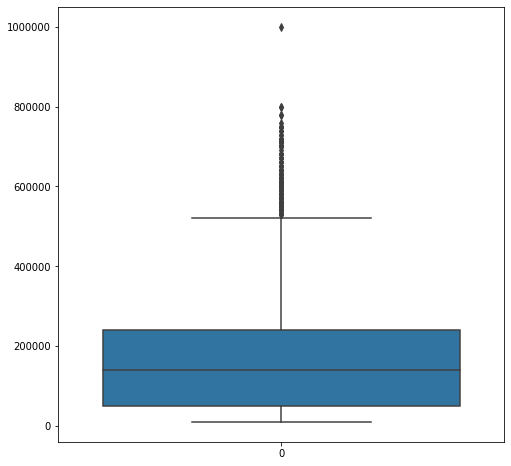

In [11]:
plt.figure(figsize=(8,8))
sns.boxplot(data = df['LIMITE'])
plt.ticklabel_format(style='plain', axis='y')


<h3><center> Informações sobre os Outliers</h3></center>

In [12]:
Q1 = df['LIMITE'].quantile(0.25)
Q3 = df['LIMITE'].quantile(0.75)
IQR = Q3 - Q1     

filtro = (df['LIMITE'] >= Q1 - 1.5 * IQR) & (df['LIMITE'] <= Q3 + 1.5 *IQR)
print('Quantidade de outliers: {:>5}\nPorcentagem de outliers: {:.2%}'.format(df['LIMITE'].size-df.loc[filtro,'LIMITE'].size,(df['LIMITE'].size-df.loc[filtro,'LIMITE'].size)/df['LIMITE'].size))

Quantidade de outliers:   167
Porcentagem de outliers: 0.56%


<h3><center>Informações Gerais sobre o Dataset</h3></center>

Número total de pessoas:  30000
------------------------------------------------------------------Inadimplência------------------------------------------------------------------

Porcentagem Adimplentes:    77.88%	Porcentagem Inadimplentes: 22.12%

---------------------------------------------------------------------Gênero----------------------------------------------------------------------

Número total de homens:   11888		Porcentagem homens:         39.63%
Número total de mulheres: 18112		Porcentagem mulheres:       60.37%

------------------------------------------------------------------Estado Civil-------------------------------------------------------------------

Porcentagem casados:      45.53%	Porcentagem solteiros:      53.21%	Porcentagem outros:       1.26%

------------------------------------------------------------------Escolaridade-------------------------------------------------------------------

Porcentagem graduados:    35.28%	Porcentagem universitários: 46.77%	Porc

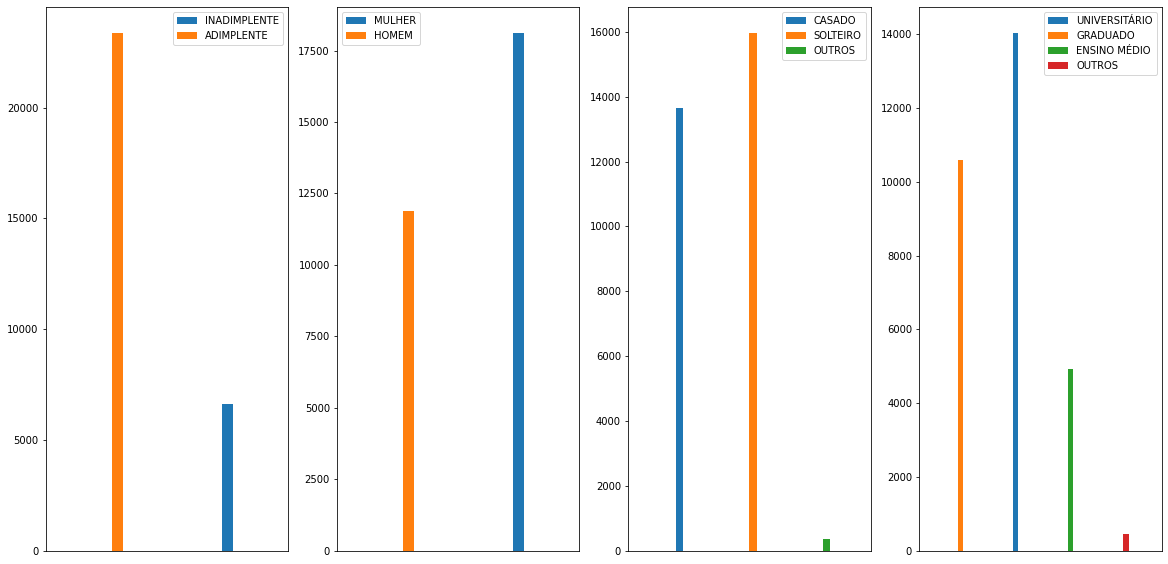

In [13]:
df_genero = df.groupby('SEXO').size()
df_estado = df.groupby('ESTADO_CIVIL').size()
df_educacao = df.groupby('EDUCACAO').size()
df_pagamento = df.groupby('PAGAMENTO').size()

total = df.shape[0]

print ('Número total de pessoas: {:>6}'.format(total))

print('{:-^145}'.format('Inadimplência'))
print('\nPorcentagem Adimplentes: {:>9.2%}\tPorcentagem Inadimplentes: {:.2%}\n'.\
        format(df_pagamento[0]/total,df_pagamento[1]/total))

print('{:-^145}'.format('Gênero'))
print('\nNúmero total de homens: {:>7}\t\tPorcentagem homens: {:>14.2%}\nNúmero total de mulheres: {}\t\tPorcentagem mulheres: {:>12.2%}\n'.\
        format(df_genero[1],df_genero[1]/total,df_genero[2],df_genero[2]/total))


print('{:-^145}'.format('Estado Civil'))
print('\nPorcentagem casados: {:>11.2%}\tPorcentagem solteiros: {:>11.2%}\tPorcentagem outros: {:>11.2%}\n'.\
        format(df_estado[1]/total,df_estado[2]/total,df_estado[3]/total))


print('{:-^145}'.format('Escolaridade'))
print('\nPorcentagem graduados: {:>9.2%}\tPorcentagem universitários: {:.2%}\tPorcentagem ensino médio: {:.2%}\tPorcentagem outros: {:.2%}\n'.\
        format(df_educacao[1]/total,df_educacao[2]/total,df_educacao[3]/total,df_educacao[4]/total))



#-----------------PLOTAGEM DE GRÁFICOS----------------------
#-----------------DEFINIÇÃO DE LEGENDAS---------------------
legenda_pag = {0 : 'ADIMPLENTE', 1 : "INADIMPLENTE"}
legenda_sex = {1 : 'HOMEM',2 : 'MULHER'}
legenda_est = {1 : 'CASADO', 2 : 'SOLTEIRO', 3 : 'OUTROS'}
legenda_edu = {1 : 'GRADUADO', 2 : 'UNIVERSITÁRIO', 3 : 'ENSINO MÉDIO', 4 : 'OUTROS'}

fig, axes = plt.subplots(1, 4, figsize=(20,10))

#-----------------SETANDO  GRÁFICOS----------------------
for entrada in df.PAGAMENTO.unique():
        axes[0].hist(x = df.loc[:,'PAGAMENTO'][df.loc[:,'PAGAMENTO'] == entrada],label = legenda_pag[entrada])

for entrada in df.SEXO.unique():
        axes[1].hist(x = df.loc[:,'SEXO'][df.loc[:,'SEXO'] == entrada],label = legenda_sex[entrada])

for entrada in df['ESTADO_CIVIL'].unique():
        axes[2].hist(x = df.loc[:,'ESTADO_CIVIL'][df.loc[:,'ESTADO_CIVIL'] == entrada],label = legenda_est[entrada])

for entrada in df['EDUCACAO'].unique():
        axes[3].hist(x = df.loc[:,'EDUCACAO'][df.loc[:,'EDUCACAO'] == entrada],label = legenda_edu[entrada])


for i in range(len(axes)):
        axes[i].legend()
        axes[i].xaxis.set_visible(False)




#### Através dos gráficos conseguimos confirmar que a maioria das pessoas é adimplente, mulher, solteira e está na universidade. Podemos verificar a relação de cada uma dessas características mais profundamente

<h3><center>Verificação da Relação da Inadimplência com as Variáveis Demográficas</h3></center>

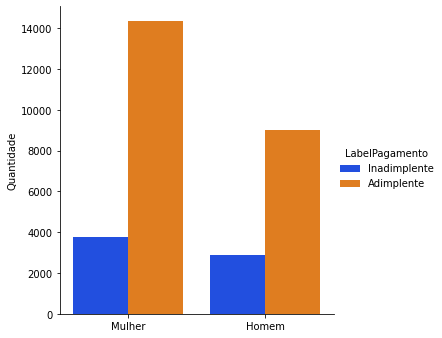

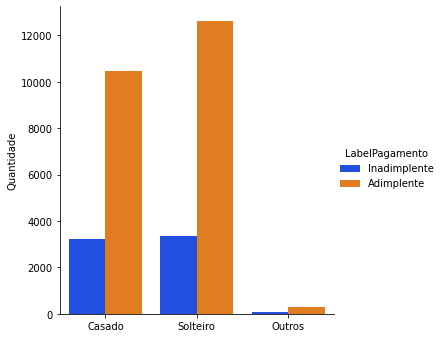

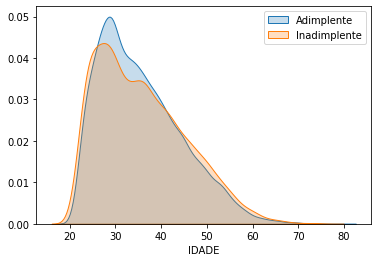

In [14]:
df['Gênero'] = df.SEXO.apply(lambda x: 'Mulher' if x == 2 else 'Homem')
df['LabelPagamento'] = df.PAGAMENTO.apply(lambda x: 'Adimplente' if x == 0 else 'Inadimplente')
df['Estado Civil'] = df['ESTADO_CIVIL'].apply(lambda x: 'Casado' if x == 1 else ('Solteiro' if x == 2 else 'Outros'))


sns.catplot(hue="LabelPagamento", kind="count", x = "Gênero", palette="bright", data=df).set(xlabel=None, ylabel = 'Quantidade')
sns.catplot(hue="LabelPagamento", kind="count", x = "Estado Civil", palette="bright", data=df).set(xlabel=None, ylabel = 'Quantidade')

plt.show()

sns.kdeplot(df.loc[(df['PAGAMENTO'] == 0), 'IDADE'], label = 'Adimplente', shade = True)
sns.kdeplot(df.loc[(df['PAGAMENTO'] == 1), 'IDADE'], label = 'Inadimplente', shade = True)

plt.ylabel('')

plt.legend()
plt.show()



## Pelos gráficos, vemos que:
#### As mulheres são a maioria do dataset, mas são os homens que são mais inadimplentes, proporcionalmente;
#### Solteiros e casados têm aproximadamente a mesma quantidade de pessoas inadimplentes, mas, por casados estarem em menor número que os solteiros, proporcionalmente as pessoas casadas são mais inadimplentes;
#### Na faixa dos 25 aos 45 anos há uma frequência maior de adimplentes em relação aos inadimplentes. Fora da faixa, a frequência de adimplentes e inadimplentes se sobrepõe.

Porcentagem dos homens que nunca atrasam: 6.04%
Porcentagem das mulheres que nunca atrasam: 11.28%


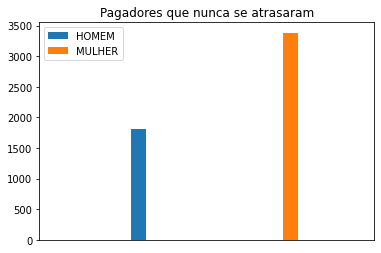

Porcentagem dos casados que nunca atrasam: 9.04%
Porcentagem dos solteiros que nunca atrasam: 8.17%
Porcentagem de outros que nunca atrasam: 0.11%


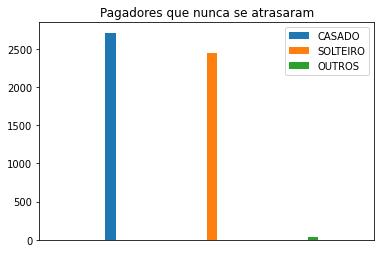

In [15]:
indices = df.loc[:,'STATUS_SET':'STATUS_ABR'].agg('sum',axis = 1)==-6
df['TOTAL FATURAS']= (df.loc[:,'FAT_AGO':'FAT_ABR'].agg('sum',axis = 1))
df['TOTAL PAGAMENTO'] = (df.loc[:,'PAG_SET':'PAG_MAI'].agg('sum',axis = 1))


print ('Porcentagem dos homens que nunca atrasam: {:.2%}'.format(df.loc[indices,'SEXO'][df.loc[indices,'SEXO'] == 1].count()/df['SEXO'].count()))
print ('Porcentagem das mulheres que nunca atrasam: {:.2%}'.format(df.loc[indices,'SEXO'][df.loc[indices,'SEXO'] == 2].count()/df['SEXO'].count()))
plt.hist(x = df.loc[indices,'SEXO'][df.loc[indices,'SEXO'] == 1],label = 'HOMEM')
plt.hist(x = df.loc[indices,'SEXO'][df.loc[indices,'SEXO'] == 2],label = 'MULHER')
plt.legend()
plt.title('Pagadores que nunca se atrasaram')
plt.xticks([], [])
plt.show()

print ('Porcentagem dos casados que nunca atrasam: {:.2%}'.format(df.loc[indices,'ESTADO_CIVIL'][df.loc[indices,'ESTADO_CIVIL'] == 1].count()/df['ESTADO_CIVIL'].count()))
print ('Porcentagem dos solteiros que nunca atrasam: {:.2%}'.format(df.loc[indices,'ESTADO_CIVIL'][df.loc[indices,'ESTADO_CIVIL'] == 2].count()/df['ESTADO_CIVIL'].count()))
print ('Porcentagem de outros que nunca atrasam: {:.2%}'.format(df.loc[indices,'ESTADO_CIVIL'][df.loc[indices,'ESTADO_CIVIL'] == 3].count()/df['ESTADO_CIVIL'].count()))
plt.hist(x = df.loc[indices,'ESTADO_CIVIL'][df.loc[indices,'ESTADO_CIVIL'] == 1],label = 'CASADO')
plt.hist(x = df.loc[indices,'ESTADO_CIVIL'][df.loc[indices,'ESTADO_CIVIL'] == 2],label = 'SOLTEIRO')
plt.hist(x = df.loc[indices,'ESTADO_CIVIL'][df.loc[indices,'ESTADO_CIVIL'] == 3],label = 'OUTROS')
plt.legend()
plt.title('Pagadores que nunca se atrasaram')
plt.xticks([], [])
plt.show()


<h3><center>Criação de Colunas para Uso do Modelo de Machine Learning</h3></center>

In [16]:
for coluna in fatura:
    df['%_LIM_'+coluna] = (df[coluna]/df['LIMITE']*100)

df['TOTAL FATURAS']= (df.loc[:,'FAT_AGO':'FAT_ABR'].agg('sum',axis = 1)) #analisando apenas de agosto para trás, pois não temos informação sobre o pagamento da fatura de setembro
df['TOTAL PAGAMENTO'] = (df.loc[:,'PAG_SET':'PAG_MAI'].agg('sum',axis = 1)) #analisando apenas de maio para frente, pois não temos informação sobre a fatura de março (que foi paga em abril)
df['RESTANTE'] = df['TOTAL FATURAS']-df['TOTAL PAGAMENTO'] #verificando a diferença entre o que foi devido e o que foi pago, saldo devedor
df['ATRASOS'] = (df.loc[:,'STATUS_SET':'STATUS_ABR'].agg('sum',axis = 1)) #verificando a soma dos status de pagamento. -6 significa nenhum atraso em todos os meses (-1*6 meses)

<h3><center>Análise da Coluna de Meses de Atraso</h3></center>

Quantidade de outliers:  2636
Porcentagem de outliers: 8.79%

count    30000.000000
mean        -0.280800
std          4.885238
min         -6.000000
25%         -4.000000
50%          0.000000
75%          0.000000
max         36.000000
Name: ATRASOS, dtype: float64


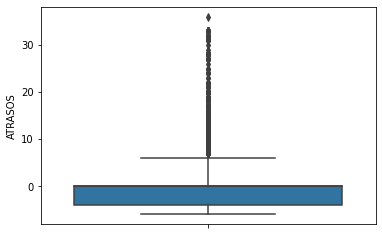

In [17]:
sns.boxplot(y = df.ATRASOS)

Q1 = df['ATRASOS'].quantile(0.25)
Q3 = df['ATRASOS'].quantile(0.75)
IQR = Q3 - Q1    

filtro = (df['ATRASOS'] >= Q1 - 1.5 * IQR) & (df['ATRASOS'] <= Q3 + 1.5 *IQR)
print('Quantidade de outliers: {:>5}\nPorcentagem de outliers: {:.2%}\n'.format(df['ATRASOS'].size-df.loc[filtro,'ATRASOS'].size,(df['ATRASOS'].size-df.loc[filtro,'ATRASOS'].size)/df['ATRASOS'].size))

print(df.ATRASOS.describe())

#### Vemos que a grande concentração das pessoas tem um atraso menor que 6 (IQR = (Q3 - Q1 = 4); Q3+1,5*IQR = 6), mas que há ~9% de pessoas que tem um atraso superior, chegando até 36.

<h3><center>Verificação da Distribuição das Idades das Pessoas que não atrasaram nenhuma Conta</h3></center>

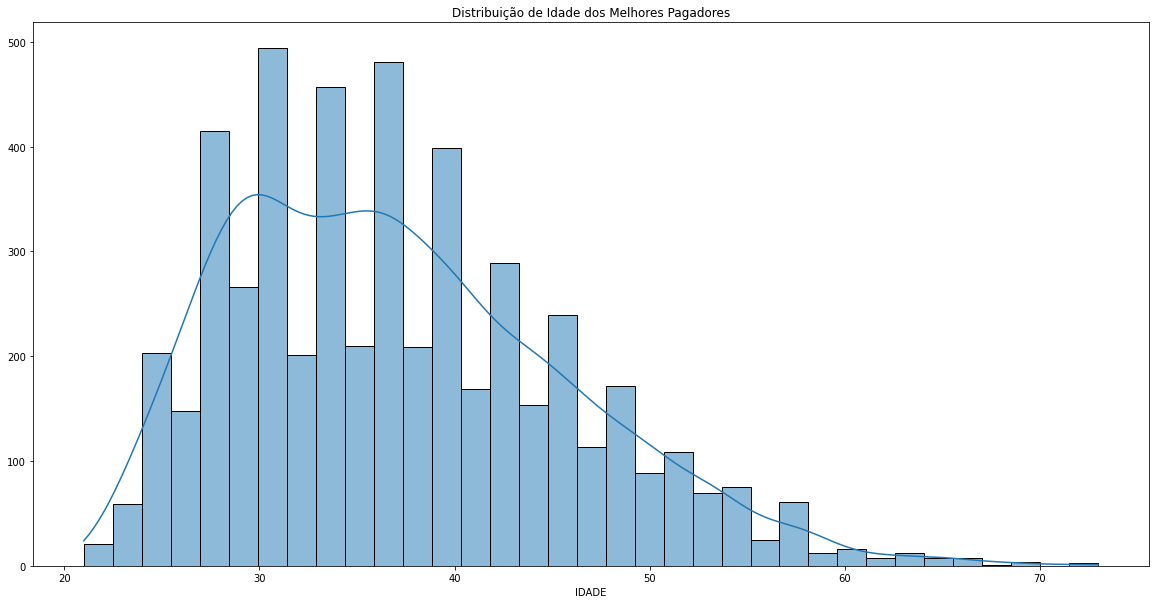

In [18]:
plt.figure(figsize=(20,10))

sns.histplot(df.loc[df.ATRASOS == -6,'IDADE'],kde = True).set(ylabel = None)
plt.title('Distribuição de Idade dos Melhores Pagadores')
plt.show()

<h2><center>Criação do Modelo de Machine Learning</h2></center>

A coluna `'PAGAMENTO'` será utilizado como target do modelo de machine learning.

Não será utilizado nenhum pré-processador, padronização, normatização, etc.

O modelo escolhido será o de Extreme Random Forest. Por enquanto iremos utilizar n_estimator como padrão, 100 árvores, e o critério como padrão também, gini. Iremos setar o random_state para termos reprodutibilidade 

In [19]:
y = df['PAGAMENTO']

X = df.drop(['PAGAMENTO','ID','Gênero','LabelPagamento','Estado Civil'],axis=1)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0,train_size=0.8)

modelo = ExtraTreesClassifier(random_state=0)
modelo.fit(train_X,train_y)

predicoes = modelo.predict(val_X)

<h3><center> Considerações dos Valores Previstos</h3></center>

In [20]:
valores_corretos = sum(predicoes == val_y)
pct_correta = valores_corretos/predicoes.size

print ('Valores absolutos identificados corretamente: {} \t Porcentagem de valores corretos: {:.2%} \t Porcentagem de valores incorretos: {:.2%}'.\
        format(valores_corretos,pct_correta,1-pct_correta))


Valores absolutos identificados corretamente: 4902 	 Porcentagem de valores corretos: 81.70% 	 Porcentagem de valores incorretos: 18.30%


<h3><center> Verificação da Quantidade de Falsos Positivos e Falsos Negativos </h3></center>

#### Falso positivo: um valor negativo no dataframe de teste e com resultado positivo na predição

#### Falso negativo: um valor positivo no dataframe de teste e com resultado negativo na predição

In [21]:
array_conf =  val_y.to_numpy()-predicoes
fp = sum(array_conf == -1)
fn = sum (array_conf == 1)

print('Total falsos positivos: {}\t Porcentagem falsos positivos: {:.2%}\nTotal falsos negativos: {}\t Porcentagem falsos negativos: {:.2%}\n'\
    .format(fp,fp/array_conf.size,fn,fn/array_conf.size))


Total falsos positivos: 288	 Porcentagem falsos positivos: 4.80%
Total falsos negativos: 810	 Porcentagem falsos negativos: 13.50%



<h3><center> Verificação das Variáveis mais Importantes para a Predição </h3></center>

In [22]:
perm = PermutationImportance(modelo, random_state=0).fit(val_X, val_y)
eli5.show_weights(perm, feature_names = val_X.columns.tolist())

Weight,Feature
0.0354 ± 0.0038,STATUS_SET
0.0015 ± 0.0024,STATUS_JUN
0.0011 ± 0.0034,ATRASOS
0.0006 ± 0.0012,IDADE
0.0002 ± 0.0029,STATUS_MAI
0.0000 ± 0.0026,SEXO
-0.0002 ± 0.0019,STATUS_JUL
-0.0005 ± 0.0021,STATUS_AGO
-0.0006 ± 0.0040,EDUCACAO
-0.0008 ± 0.0013,%_LIM_FAT_JUN


<h1><center> Conclusão </h1></center>

#### Vemos que dentro os gêneros, as mulheres são melhores pagadoras
#### Entre os diferentes estados civis, os casados possuem a maior taxa de inadimplência
#### Que com o modelo proposto, temos 81,7% de taxa de acerto
#### A variável mais importante para predição foi o status do pagamento no mês anterior (setembro)